## Фреймворк PyTorch для разработки искусственных нейронных сетей

### Домашнее задание №4

**Урок 4. CNN Свертки**

1. Обучите CNN (самописная) на CIFAR-100.
2. Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50.
3. *Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50 с аугментацией данных.

**Библиотеки**

In [3]:
import numpy as np
import torch

from torch import nn
from torch.nn import functional as F
from PIL import Image
from torchvision import transforms, datasets
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [4]:
dataset = datasets.CIFAR100(root='sample_data/', train=True, download=True)

  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting sample_data/cifar-100-python.tar.gz to sample_data/


#### Обучите CNN (самописная) на CIFAR-100

In [5]:
class MyOwnCifar(torch.utils.data.Dataset):
   
    def __init__(self, init_dataset, transform=None):
        self._base_dataset = init_dataset
        self.transform = transform

    def __len__(self):
        return len(self._base_dataset)

    def __getitem__(self, idx):
        img = self._base_dataset[idx][0]
        if self.transform is not None:
            img = self.transform(img)
        return img, self._base_dataset[idx][1]

In [6]:
img_size = 32

In [7]:
trans_actions = transforms.Compose([transforms.Resize(img_size + 2),
                                    transforms.RandomCrop(img_size, padding=2), 
                                    transforms.ToTensor()])

In [8]:
def train_valid_split(Xt):
    X_train, X_test = train_test_split(Xt, test_size=0.05, random_state=13)
    return X_train, X_test

train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, trans_actions)
valid_dataset = MyOwnCifar(valid_dataset, transforms.ToTensor())

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                          batch_size=128,
                          shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                          batch_size=128,
                          shuffle=False)

In [10]:
classes = {
    0: 'apple',
    1: 'aquarium_fish',
    2: 'baby',
    3: 'bear',
    4: 'beaver',
    5: 'bed',
    6: 'bee',
    7: 'beetle',
    8: 'bicycle',
    9: 'bottle',
    10: 'bowl',
    11: 'boy',
    12: 'bridge',
    13: 'bus',
    14: 'butterfly',
    15: 'camel',
    16: 'can',
    17: 'castle',
    18: 'caterpillar',
    19: 'cattle',
    20: 'chair',
    21: 'chimpanzee',
    22: 'clock',
    23: 'cloud',
    24: 'cockroach',
    25: 'couch',
    26: 'cra',
    27: 'crocodile',
    28: 'cup',
    29: 'dinosaur',
    30: 'dolphin',
    31: 'elephant',
    32: 'flatfish',
    33: 'forest',
    34: 'fox',
    35: 'girl',
    36: 'hamster',
    37: 'house',
    38: 'kangaroo',
    39: 'keyboard',
    40: 'lamp',
    41: 'lawn_mower',
    42: 'leopard',
    43: 'lion',
    44: 'lizard',
    45: 'lobster',
    46: 'man',
    47: 'maple_tree',
    48: 'motorcycle',
    49: 'mountain',
    50: 'mouse',
    51: 'mushroom',
    52: 'oak_tree',
    53: 'orange',
    54: 'orchid',
    55: 'otter',
    56: 'palm_tree',
    57: 'pear',
    58: 'pickup_truck',
    59: 'pine_tree',
    60: 'plain',
    61: 'plate',
    62: 'poppy',
    63: 'porcupine',
    64: 'possum',
    65: 'rabbit',
    66: 'raccoon',
    67: 'ray',
    68: 'road',
    69: 'rocket',
    70: 'rose',
    71: 'sea',
    72: 'seal',
    73: 'shark',
    74: 'shrew',
    75: 'skunk',
    76: 'skyscraper',
    77: 'snail',
    78: 'snake',
    79: 'spider',
    80: 'squirrel',
    81: 'streetcar',
    82: 'sunflower',
    83: 'sweet_pepper',
    84: 'table',
    85: 'tank',
    86: 'telephone',
    87: 'television',
    88: 'tiger',
    89: 'tractor',
    90: 'train',
    91: 'trout',
    92: 'tulip',
    93: 'turtle',
    94: 'wardrobe',
    95: 'whale',
    96: 'willow_tree',
    97: 'wolf',
    98: 'woman',
    99: 'worm'}

torch.Size([128, 3, 32, 32])
motorcycle


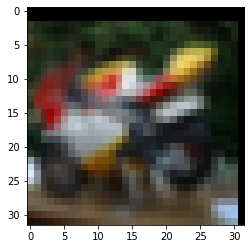

In [11]:
import matplotlib.pyplot as plt


for img, lbl in train_loader:
    print(img.shape)
    print(classes[int(lbl[0])])
    plt.imshow(img[0].permute(1, 2, 0))
    break

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [13]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.dp_one = nn.Dropout(0.2)
        self.dp_two = nn.Dropout(0.2)
        
        self.bn_one = torch.nn.BatchNorm2d(3) 
        self.conv_one = torch.nn.Conv2d(3, 30, 3)
        self.bn_two = torch.nn.BatchNorm2d(30) 
        self.conv_two = torch.nn.Conv2d(30, 60, 3)
        self.bn_three = torch.nn.BatchNorm2d(60)
        self.conv_three = torch.nn.Conv2d(60, 120, 3)
        self.bn_four = torch.nn.BatchNorm2d(120)
        self.fc1 = torch.nn.Linear(480, 300)
        self.fc2 = torch.nn.Linear(300, 160)
        self.out = torch.nn.Linear(160, 100)
        
    def forward(self, x):
        x = self.bn_one(x)
        x = self.conv_one(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_two(x)
        x = self.conv_two(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_three(x)
        x = self.conv_three(x)
        x = F.leaky_relu(x, 0.1)
        x = F.max_pool2d(x, 2)
        
        x = self.bn_four(x)
        x = x.view(x.size(0), -1)
        x = self.dp_one(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dp_two(x)
        x = self.fc2(x)
        x = F.relu(x)
        return self.out(x)
       
net = Net().to(device)
print(net)

Net(
  (dp_one): Dropout(p=0.2, inplace=False)
  (dp_two): Dropout(p=0.2, inplace=False)
  (bn_one): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_one): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1))
  (bn_two): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_two): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
  (bn_three): BatchNorm2d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_three): Conv2d(60, 120, kernel_size=(3, 3), stride=(1, 1))
  (bn_four): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=480, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=160, bias=True)
  (out): Linear(in_features=160, out_features=100, bias=True)
)


In [14]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [ ]:
!pip install torchsummary==1.5.1

In [15]:
from torchsummary import summary
summary(net.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1            [-1, 3, 32, 32]               6
            Conv2d-2           [-1, 30, 30, 30]             840
       BatchNorm2d-3           [-1, 30, 15, 15]              60
            Conv2d-4           [-1, 60, 13, 13]          16,260
       BatchNorm2d-5             [-1, 60, 6, 6]             120
            Conv2d-6            [-1, 120, 4, 4]          64,920
       BatchNorm2d-7            [-1, 120, 2, 2]             240
           Dropout-8                  [-1, 480]               0
            Linear-9                  [-1, 300]         144,300
          Dropout-10                  [-1, 300]               0
           Linear-11                  [-1, 160]          48,160
           Linear-12                  [-1, 100]          16,100
Total params: 291,006
Trainable params: 291,006
Non-trainable params: 0
-------------------------------

In [16]:
%%time
num_epochs = 50
net.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 200 == 0:    # печатаем каждые 300 mini-batches
            net.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = net(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')
        
        net.train()
        
print('Training is finished!')

Epoch [1/50]. Step [1/372]. Loss: 0.036. Acc: 0.008. Test acc: 0.012
Epoch [1/50]. Step [201/372]. Loss: 0.033. Acc: 0.059. Test acc: 0.082
Epoch [2/50]. Step [1/372]. Loss: 0.030. Acc: 0.078. Test acc: 0.108
Epoch [2/50]. Step [201/372]. Loss: 0.029. Acc: 0.115. Test acc: 0.130
Epoch [3/50]. Step [1/372]. Loss: 0.028. Acc: 0.188. Test acc: 0.155
Epoch [3/50]. Step [201/372]. Loss: 0.028. Acc: 0.154. Test acc: 0.158
Epoch [4/50]. Step [1/372]. Loss: 0.025. Acc: 0.195. Test acc: 0.164
Epoch [4/50]. Step [201/372]. Loss: 0.026. Acc: 0.185. Test acc: 0.172
Epoch [5/50]. Step [1/372]. Loss: 0.024. Acc: 0.258. Test acc: 0.196
Epoch [5/50]. Step [201/372]. Loss: 0.025. Acc: 0.210. Test acc: 0.214
Epoch [6/50]. Step [1/372]. Loss: 0.025. Acc: 0.180. Test acc: 0.214
Epoch [6/50]. Step [201/372]. Loss: 0.025. Acc: 0.226. Test acc: 0.231
Epoch [7/50]. Step [1/372]. Loss: 0.025. Acc: 0.195. Test acc: 0.231
Epoch [7/50]. Step [201/372]. Loss: 0.024. Acc: 0.237. Test acc: 0.260
Epoch [8/50]. Step [

#### Обучите CNN на CIFAR-100 через дообучение ImageNet Resnet-50

In [18]:
from torchvision import models

resnet50 = models.resnet50(pretrained=True)
print(resnet50)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
from torchsummary import summary
summary(resnet50.to(device), input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [20]:
for param in list(resnet50.parameters())[:]:
    param.requires_grad = False

In [21]:
resnet50.fc = nn.Linear(2048, 100)

summary(resnet50.to(device), input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [22]:
resnet50 = resnet50.to(device)

###  
The inference transforms are available at ResNet50_Weights.IMAGENET1K_V2.transforms and 
perform the following preprocessing operations: Accepts PIL.Image, batched (B, C, H, W) 
and single (C, H, W) image torch.Tensor objects. The images are resized to resize_size=[232] 
using interpolation=InterpolationMode.BILINEAR, followed by a central crop of crop_size=[224]. 
Finally the values are first rescaled to [0.0, 1.0] and then normalized using mean=[0.485, 0.456, 0.406] 
and std=[0.229, 0.224, 0.225].  

**mean = [0.485, 0.456, 0.406]  
std = [0.229, 0.224, 0.225]**

In [23]:
train_actions = transforms.Compose([transforms.Resize(256),
                                    transforms.RandomCrop(224, padding=4), 
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])
valid_transforms = transforms.Compose([transforms.Resize(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])


train_dataset, valid_dataset = train_valid_split(dataset)

train_dataset = MyOwnCifar(train_dataset, train_actions)
valid_dataset = MyOwnCifar(valid_dataset, valid_transforms)

In [24]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=128,
                                           shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=128,
                                           shuffle=False)

In [25]:
params_to_update = []
for name, param in resnet50.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)


optimizer = torch.optim.Adam(params_to_update, lr=0.001)
criterion = nn.CrossEntropyLoss()

In [27]:
%%time
num_epochs = 5
resnet50.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 200 == 0:    # печатаем каждые 300 mini-batches
            resnet50.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = resnet50(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')

        resnet50.train()
        
print('Training is finished!')

Epoch [1/5]. Step [1/372]. Loss: 0.012. Acc: 0.570. Test acc: 0.574
Epoch [1/5]. Step [201/372]. Loss: 0.012. Acc: 0.577. Test acc: 0.558
Epoch [2/5]. Step [1/372]. Loss: 0.011. Acc: 0.609. Test acc: 0.558
Epoch [2/5]. Step [201/372]. Loss: 0.012. Acc: 0.581. Test acc: 0.588
Epoch [3/5]. Step [1/372]. Loss: 0.012. Acc: 0.570. Test acc: 0.562
Epoch [3/5]. Step [201/372]. Loss: 0.011. Acc: 0.598. Test acc: 0.584
Epoch [4/5]. Step [1/372]. Loss: 0.010. Acc: 0.602. Test acc: 0.568
Epoch [4/5]. Step [201/372]. Loss: 0.011. Acc: 0.598. Test acc: 0.572
Epoch [5/5]. Step [1/372]. Loss: 0.011. Acc: 0.602. Test acc: 0.563
Epoch [5/5]. Step [201/372]. Loss: 0.011. Acc: 0.605. Test acc: 0.578
Training is finished!
CPU times: user 20min 58s, sys: 1min 17s, total: 22min 15s
Wall time: 22min 24s


In [17]:
###Выводы:
Как мы видим из результатов тренировки, предобученная сеть показывает результат на уровень выше самописной за счет своей более сложной архитектуры и самой предобученности.
однако ее дообучение является более длительным и сложным процессом по сравнению с самописной сетью, сделанной "на коленке"
Самописная сеть:
num_epochs = 50
Wall time: 13min 42s
Epoch [49/50]. Step [1/372]. Loss: 0.018. Acc: 0.438. Test acc: 0.377
Предобученная сеть:
num_epochs = 5



In [ ]:
%%time
num_epochs = 5
resnet50.train()

for epoch in range(num_epochs):  
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        # обнуляем градиент
        optimizer.zero_grad()

        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # выводим статистику о процессе обучения
        running_loss += loss.item()
        running_items += len(labels)
        running_right += (labels == torch.max(outputs, 1)[1]).sum()
        
        # выводим статистику о процессе обучения
        if i % 200 == 0:    # печатаем каждые 300 mini-batches
            resnet50.eval()
            
            print(f'Epoch [{epoch + 1}/{num_epochs}]. ' \
                  f'Step [{i + 1}/{len(train_loader)}]. ' \
                  f'Loss: {running_loss / running_items:.3f}. ' \
                  f'Acc: {running_right / running_items:.3f}', end='. ')
            running_loss, running_items, running_right = 0.0, 0.0, 0.0

            test_running_right, test_running_total = 0.0, 0.0
            for i, data in enumerate(valid_loader):
            
                test_outputs = resnet50(data[0].to(device))
                test_running_total += len(data[1])
                test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()
            
            print(f'Test acc: {test_running_right / test_running_total:.3f}')

        resnet50.train()
        
print('Training is finished!')

Epoch [1/5]. Step [1/372]. Loss: 0.012. Acc: 0.570. Test acc: 0.574
Epoch [1/5]. Step [201/372]. Loss: 0.012. Acc: 0.577. Test acc: 0.558
Epoch [2/5]. Step [1/372]. Loss: 0.011. Acc: 0.609. Test acc: 0.558
Epoch [2/5]. Step [201/372]. Loss: 0.012. Acc: 0.581. Test acc: 0.588
Epoch [3/5]. Step [1/372]. Loss: 0.012. Acc: 0.570. Test acc: 0.562
Epoch [3/5]. Step [201/372]. Loss: 0.011. Acc: 0.598. Test acc: 0.584
Epoch [4/5]. Step [1/372]. Loss: 0.010. Acc: 0.602. Test acc: 0.568
Epoch [4/5]. Step [201/372]. Loss: 0.011. Acc: 0.598. Test acc: 0.572
Epoch [5/5]. Step [1/372]. Loss: 0.011. Acc: 0.602. Test acc: 0.563
Epoch [5/5]. Step [201/372]. Loss: 0.011. Acc: 0.605. Test acc: 0.578
Training is finished!
CPU times: user 20min 58s, sys: 1min 17s, total: 22min 15s
Wall time: 22min 24s


### Выводы  
Самописная сеть:  
num_epochs = 50  
Wall time: 13min 42s  
Epoch [49/50]. Step [1/372]. Loss: 0.018. Acc: 0.438. Test acc: 0.377  
Предобученная сеть:  
num_epochs = 5  
Wall time: 22min 24s  
Epoch [5/5]. Step [201/372]. Loss: 0.011. Acc: 0.605. Test acc: 0.57  